![example](images/director_shot.jpeg)

# Microsoft Studios - 3 Keys to Success 

By: Aalok Joshi, Jerry Vasquez, Zach Hanly, TJ Bray

## Overview

This project analyzed what types of films are currently doing best at the box office for Microsoft to potentially get into original video content. Using descriptive statistics and data from various online databases with information about movies, we have identified three solution areas within which we make recommendations. These are business partnerships, content selection and personnel/hiring.

## Business Problem

Microsoft Studios has decided to create a new movie studio to create original video content like other big companies are doing. However, this is easier said than done. We see three main roadblocks or problems to expanding this line of business for Microsoft. Firstly this is a saturated marketplace that everyone seems intent on entering. Secondly, though Microsoft has experience in a variety of different industries, content production and streaming platforms are not amongst them. This lack of prior experience can result in expensive mistakes (i.e. Tubi or the Microsoft Zune). Finally the lack of experience also rolls over into Microsoft Studios’ lack of subject matter experts (directors, writers, etc.) and domain specific knowledge.

## Data Understanding

The date is from five different sources: IMDB and Box Office Mojo by IMDb, Rotten Tomatoes, The Movie Database, and The Numbers. It was joined using unique ids for movies and crew, and also using movie names.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline

In [2]:
# Here you run your code to explore the data

# Box Office Mojo by IMDb Pro
movie_gross_df = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')

# IMDb
imdb_name_df = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
imdb_akas_df = pd.read_csv('data/zippedData/imdb.title.akas.csv.gz')
imdb_basics_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
imdb_crew_df = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz')
imdb_principals_df = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
imdb_ratings_df = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')

# Rotten Tomatos
rt_movies_df = pd.read_csv('data/zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews_df = pd.read_csv('data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')

# The Movie Database
tmdb_movies_df = pd.read_csv('data/zippedData/tmdb.movies.csv.gz')

# The Numbers
tn_budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## Data Preparation

### Mapping Fresh Score to 0/1 and Normalizing Rating Systems

In [18]:
joinedrt = rt_movies_df.set_index('id').join(rt_reviews_df, on = 'id', lsuffix = ' guidelines', rsuffix =' critical')
joinedrt = joinedrt.dropna(subset = ['runtime'])
joinedrt['freshnum'] = joinedrt['fresh'].map({'fresh': 1, 'rotten': 0})

The rating systems for different critics and their respective websites vary drastically. This can be anything from an A-F rating or a 0-100 rating with demicals. I normalized all of the ratings on a scale of 0-100 without decimals.

In [19]:
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'3/4' : 75, '4/5' : 80, '3/5' : 60, '1/4': 25, '1/5': 20,'3.5/4' : 87, '2/5': 40, '2/4': 50, '3.7/5': 74})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'2.5/4': 63, '3.5/5' : 70, '5/5': 100, 'B': 85, '4/4': 100, 'B+': 88, "A-": 93, '2.5/5' : 50, "8/10" : 80, 'B-': 82, '4.5/5': 90, '1.5/4': 37.5, 'A': 95, '6/10': 60, 'C+': 77, '9/10': 90, "C": 74, 'C-': 72, '5/10': 50, '1.5/5': 30, '7/10': 70})
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'0/5':0, '8': 80, '1': 10, '4/10': 40, 'D+': 69, '7': 70, '3/10': 30, 'D': 67, "0.5/4": 13, '6': 60}) 
joinedrt['rating critical'] = joinedrt['rating critical'].replace({"3": 30, "D-": 66, "1/10": 10, '0/4' : 0, '8.5/10': 85, "A+": 98, '4.0/4': 100, "8.4/10": 84, "9": 90, "F": 35, "7.5/10": 75, "7.7": 77, "2": 20, "0": 0, "2.0/5": 40, '0.5/10': 5}) 
joinedrt['rating critical'] = joinedrt['rating critical'].replace({'2/10': 20, '5.0/5': 100, '3.0/5': 60, "2.5": 50, '5': 50, '2.2/5': 44})

### Studio Data Cleaning & Visualization

Next I took a look at the Studio Data and realized that the studios have many duplicate entities. For example, "20th Century Fox Distribution" shouldn't be counted as a different movie house than "20th Century Fox" because they are under the same umbrella. 

In [16]:
joinedrt['studio'] = joinedrt['studio'].replace({'Sony Pictures Classics':'Sony Pictures',  '20th Century Fox Distribution': '20th Century Fox','20th Century Fox Film Corporat': '20th Century Fox', 'A24': 'A24 Films', 'A24 and DIRECTV': 'A24 Films', 'Sony Pictures Releasing': 'Sony Pictures'})
joinedrt['studio'] = joinedrt['studio'].replace({'Lions Gate Films': "Lionsgate Films", 'Lionsgate': 'Lionsgate Films', "Paramount Vantage": "Paramount Pictures", 'Paramount Classics': "Paramount Pictures", "Paramount": 'Paramount Pictures'})
joinedrt['studio'] = joinedrt['studio'].replace({'Sony Pictures Home Entertainment':'Sony Pictures','Warner Bros. Pictures':'Warner Bros.', 'Universal Studios':'Universal Pictures','Sony Pictures Entertainment':'Sony Pictures','Sony Classics':'Sony Pictures', 'Paramount Home Video': 'Paramount Pictures', 'Universal':'Universal Pictures','Lions Gate':"Lionsgate Films",'Dreamworks/Paramount':'Paramount Pictures','Universal Pictures International':'Universal Pictures','Paramount Studios': 'Paramount Pictures'})                                       
joinedrt['studio'] = joinedrt['studio'].replace({'Lionsgate/Roadside Attractions': "Lionsgate Films", 'WARNER BROTHERS PICTURES': 'Warner Bros', 'Lions Gate Releasing':'Lionsgate Films','Twentieth Century Fox':'20th Century Fox','Fox International':'20th Century Fox','Lionsgate Films/After Dark Films':'Lionsgate Films', 'Universal Pictures Distributio':'Universal Pictures','Miramax':'Miramax Films'})
joinedrt['studio'] = joinedrt['studio'].replace({'Sony Pictures/Columbia':'Sony Pictures','IFC':'IFC Films','Sony Pictures/TriStar Pictures':'Sony Pictures'})
joinedrt['studio'] = joinedrt['studio'].replace({'Twentieth Century Fox Home Entertainment':'20th Century Fox','IFC First Take':'IFC Films','Lions Gate Films Inc.':'Lionsgate Films', 'WB':'Warner Bros.','Fox':'20th Century Fox','Warner Bros':'Warner Bros.','Walt Disney Animation Studios':'Walt Disney Pictures','Disneynature':'Walt Disney Pictures','Weinstein Company':'The Weinstein Company','The Weinstein Co.':'The Weinstein Company'})
joinedrt['studio'] = joinedrt['studio'].replace({'Weinstein Co.':'The Weinstein Company','Universal Studios Home Video':'Universal Pictures','United Artists Pictures/MGM':'MGM','Fox Searchlight':'Fox Searchlight Pictures','Sony Pictures/Columbia Pictures':'Columbia Pictures','Universal Studios Home Video':'Universal Pictures','New Line Home Entertainment':'New Line Cinema','Screen Gems/SONY PICTURES':'Sony Pictures','MGM/UA':'MGM','Buena Vista Distribution Compa':'Buena Vista Pictures'})

In [17]:
joinedrtstudio = joinedrt.sort_values('studio')
joinedrtstudiocleaned = joinedrtstudio.dropna(subset=['studio'])
joinedrtstudiocleaned2 = joinedrtstudiocleaned.groupby('studio').mean()
joinedrtstudiocleaned2['numberofmovies'] = joinedrt['studio'].value_counts()

Cleaning for Genres 

For this investigation, our goal will be to find what movie genres are commonly rated high among viewers in order make recommendations on what genres our movies should be. We start by merging the necessary dateframes to load the IMDb and Rotten Tomatoes data. And continue by addressing the missing values in each dataframe.

In [20]:
# Merging IMDb dfs and dropping NaNs
imdb_basics_rating = pd.merge(left=imdb_basics_df,right=imdb_ratings_df,
                               on='tconst',how='inner')
imdb_basics_rating = imdb_basics_rating[imdb_basics_rating['genres'].isna() != True]

# Only interesting in movies with at 8 rating or above
imdb_ratings_over_8 = imdb_basics_rating[imdb_basics_rating['averagerating'] >= 8]

# Merging Rotten Tomatoes dfs and dropping NaNs
rt_reviews_df.dropna(inplace=True)
joinedrt_copy = joinedrt.copy()
joinedrt_copy = rt_movies_df.set_index('id').join(rt_reviews_df, on = 'id', lsuffix = ' guidelines', rsuffix =' critical')
joinedrt_copy = joinedrt_copy.dropna(subset = ['runtime'])

# Creating one unified measurement scale for the Rotten Tomatoes ratings column 
joinedrt_copy['freshnum'] = joinedrt_copy['fresh'].map({'fresh': 1, 'rotten': 0})
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'3/4' : 75, '4/5' : 80, '3/5' : 60, '1/4': 25, '1/5': 20,'3.5/4' : 87, '2/5': 40, '2/4': 50, '3.7/5': 74})
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'2.5/4': 63, '3.5/5' : 70, '5/5': 100, 'B': 85, '4/4': 100, 'B+': 88, "A-": 93, '2.5/5' : 50, "8/10" : 80, 'B-': 82, '4.5/5': 90, '1.5/4': 37.5, 'A': 95, '6/10': 60, 'C+': 77, '9/10': 90, "C": 74, 'C-': 72, '5/10': 50, '1.5/5': 30, '7/10': 70})
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'0/5':0, '8': 80, '1': 10, '4/10': 40, 'D+': 69, '7': 70, '3/10': 30, 'D': 67, "0.5/4": 13, '6': 60}) 
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({"3": 30, "D-": 66, "1/10": 10, '0/4' : 0, '8.5/10': 85, "A+": 98, '4.0/4': 100, "8.4/10": 84, "9": 90, "F": 35, "7.5/10": 75, "7.7": 77, "2": 20, "0": 0, "2.0/5": 40, '0.5/10': 5}) 
joinedrt_copy['rating critical'] = joinedrt_copy['rating critical'].replace({'2/10': 20, '5.0/5': 100, '3.0/5': 60, "2.5": 50, '5': 50, '2.2/5': 44})


joinedrt_copy['rating critical'] = joinedrt_copy['rating critical']/10

# Filtering movies with a rating of 8 or above
rt_ratings_over_8 = joinedrt_copy[joinedrt_copy['rating critical'] >= 8]

<br>

### Cleaning for Directors 

Finding the best directors by worlwide gross and movie rating:
- Begin with a main DatFrame of all movie titles from the US region and drop the extra rows for movies listed more than once.
- Then add the ratings for each movie by joining with the Imdb ratings csv and reduce columns to only the movies unique id, name and average rating.  


Add Directors, their name and the "worldwide gross" for each movie:
- Build another DataFrame from the IMDb priciples csv containing only those in the director category, then attach to main DataFrame using each movies unique id. 
- Then use each directors unique id to add on their name contained in the IMDb name csv.
- Add each movies domestic and foreign gross contaied in the movie gross csv from Box Office Mojo by IMDb Pro and create a worldwide gross column by adding those two columns.

Orgonizing DateFrame by director:
- Drop rows that do not have either a name for the movie director or a value for worldwide gross
- Grouping the movies by director and reducing columns to the average worldwide gross and the average rating

In [3]:
# Here you run your code to clean the data
# finding top 20 directors
titles = imdb_akas_df[imdb_akas_df['region'] == 'US'].drop_duplicates(subset=['title_id'])
add_ratings = titles.join(imdb_ratings_df.set_index('tconst'), on='title_id')
add_ratings = add_ratings[['title_id', 'title', 'averagerating',]]

# add directors names and make worldwid gross column
directors = imdb_principals_df[imdb_principals_df['category'] == 'director']
add_director = add_ratings.join(directors.set_index('tconst'), on='title_id')
add_dir_name = add_director.join(imdb_name_df.set_index('nconst'), on='nconst')
add_gross = add_dir_name.join(movie_gross_df.set_index('title'), on='title')

add_gross['foreign_gross'] = add_gross['foreign_gross'].str.replace(',', '').apply(lambda x: float(x))
add_gross['worldwide_gross'] = add_gross['domestic_gross'] + add_gross['foreign_gross']

# isolate directors only 
dropped = add_gross.dropna(subset=['primary_name','worldwide_gross'])
director_df = add_gross.dropna(subset=['primary_name','worldwide_gross'])
director_df = director_df[['primary_name', 'worldwide_gross', 'averagerating']]

# categorize directors performance in gross and ratings amonst the dataset
mean_gross = director_df.worldwide_gross.mean()
mean_rating = director_df.averagerating.mean()
director_df['high_gross'] = (director_df['worldwide_gross'] > mean_gross).apply(int)
director_df['high_rating'] = (director_df['averagerating'] > mean_rating).apply(int)
director_df['Categories Above Mean'] = director_df['high_gross'] + director_df['high_rating']

### Cleaning for top writers

I created Dataframes for the data I am going to work with. Movie title, writer name, and movie ROI.
I searched through the crew name database and matched up the writers names with the nconst code.
I merged the dataframes to create a data frame with all the necessary information to find the writers that provide the greatest ROI.

In [4]:
# cleaning data from given CSVs
imdb_basics = imdb_basics_df
imdb_basics = imdb_basics.rename(columns = {'primary_title' : 'title'})

# create Profit column
tn_budgets = tn_budgets_df
tn_budgets = tn_budgets.rename(columns = {'movie' : 'title'})
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['profit'] = tn_budgets['worldwide_gross'] - tn_budgets['production_budget']

# merge movies with financial data
movie_gross_and_basics = imdb_basics.merge(tn_budgets, how = 'inner', on ='title')
movie_gross_and_basics = movie_gross_and_basics.drop_duplicates(subset = ['title'])

# clean crew data
imdb_name = imdb_name_df
imdb_crew = imdb_crew_df
imdb_crew = imdb_crew.merge(movie_gross_and_basics[['title', 'tconst']], on = 'tconst', how = 'left', validate = 'one_to_many')
imdb_crew = imdb_crew.dropna(subset = ['title'])

#clean ratings data
imdb_ratings = imdb_ratings_df
imdb_ratings = imdb_ratings.merge(movie_gross_and_basics, on = 'tconst', how = 'left', validate = 'one_to_many')
imdb_ratings = imdb_ratings.dropna(subset = ['title']).sort_values('averagerating', ascending = False).drop(columns = ['original_title'], axis = 1)
imdb_ratings['release_date'] = pd.to_datetime(imdb_ratings['release_date'])

#separate writers and create Return on Investment
writers = imdb_crew.assign(writers = lambda x :imdb_crew['writers'].str.split(','))
writers_profit = writers.explode('writers').merge(imdb_ratings, on = 'tconst', how = 'left', validate = 'many_to_one')
writers_profit['ROI'] = writers_profit['profit']/writers_profit['production_budget']*100
writers_profit = writers_profit.dropna(subset = ['ROI'])
writers_profit = writers_profit.merge(imdb_name[['primary_name', 'nconst']], left_on = ['writers'], right_on = 'nconst', how = 'left', validate = 'many_to_one')
writers_profit = writers_profit.merge(imdb_basics[['tconst', 'title']], on = 'tconst', how = 'left', validate = 'many_to_one')

/var/folders/z6/fcq5hpx5439g33rb41t6sgmm0000gn/T/ipykernel_7765/2329679106.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace("$","").str.replace(",","").astype(float)
/var/folders/z6/fcq5hpx5439g33rb41t6sgmm0000gn/T/ipykernel_7765/2329679106.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace("$","").str.replace(",","").astype(float)


## Data Modeling

For modeling the genre popularity, we extract all the genre categories in our filtered and cleaned dataframes. Then we build two frequency dictionaries for the IMDb and Rotten Tomatoes movie genres. Using these frequency dictionaries, we are able to construct frequency charts of the top 5 movie genres for each IMDb and Rotten Tomatoes.

In [21]:
#Creating a list of all the Genres of the movies with an 8 rating or above for IMDb
genres = list(imdb_ratings_over_8['genres'])

genres_list = []

for genre in genres:
    List = str(genre).split(',')
    for individual_genre in List:
        genres_list.append(individual_genre)

# Creating a frequency dictionary for each genre
genre_frequency = {}
for element in genres_list:
    if element in genre_frequency:
        genre_frequency[element] += 1
    else:
        genre_frequency[element] = 1

# Sorted dictionary for IMDb
sorted_imdb_genres = {k: v for k, v in sorted(genre_frequency.items(), key=lambda item: item[1])}

# Same procedure to create a frequency for the Rotten Tomatoes movies
genres = list(rt_ratings_over_8['genre'])
genres_list_2 = []
for genre in genres:
    List = str(genre).split('|')
    for individual_genre in List:
        genres_list_2.append(individual_genre)
        
genre_frequency_2 = {}
for element in genres_list_2:
    if element in genre_frequency_2:
        genre_frequency_2[element] += 1
    else:
        genre_frequency_2[element] = 1
        
# Sorted dictionary for Rotten Tomatoes
sorted_rt_genres = {k: v for k, v in sorted(genre_frequency_2.items(), key=lambda item: item[1])}

<br>

Find the correlation between each director's movie's worldwide gross and the average rating of their movies

In [7]:
# correlation
corr_per_movie = director_df[['averagerating', 'worldwide_gross']].corr().iloc[0][1].round(2)
print(f'Correlation between worldwide gross and rating per movie: {corr_per_movie}')

Correlation between worldwide gross and rating per movie: 0.19


In [8]:
#find top writers based on Return on Investment
top_writers = writers_profit.where(writers_profit['ROI'] > 1).sort_values('ROI', ascending = False)
top_writers_2000 = top_writers[(top_writers['release_date'] > '2000-1-1')]
writers_plot = top_writers_2000.groupby('primary_name').mean('ROI').sort_values('ROI', ascending = False)[:30]
wnames = writers_plot.index
wratings = writers_plot.averagerating.values.round(2)
wnames_wrating = [x+': '+str(y) for x,y in zip(wnames,wratings)]

### Visualizations

In [22]:
joinedrtstudio = joinedrt.sort_values('studio')
joinedrtstudiocleaned = joinedrtstudio.dropna(subset=['studio'])
joinedrtstudiocleaned2 = joinedrtstudiocleaned.groupby('studio').mean()
joinedrtstudiocleaned2['numberofmovies'] = joinedrt['studio'].value_counts()

In [23]:
toptenstudios = joinedrtstudiocleaned2.sort_values(by = 'numberofmovies', ascending = False)[:10]
toptenstudios = toptenstudios.sort_values(by='rating critical', ascending = False)
toptenstudios = toptenstudios.reset_index()

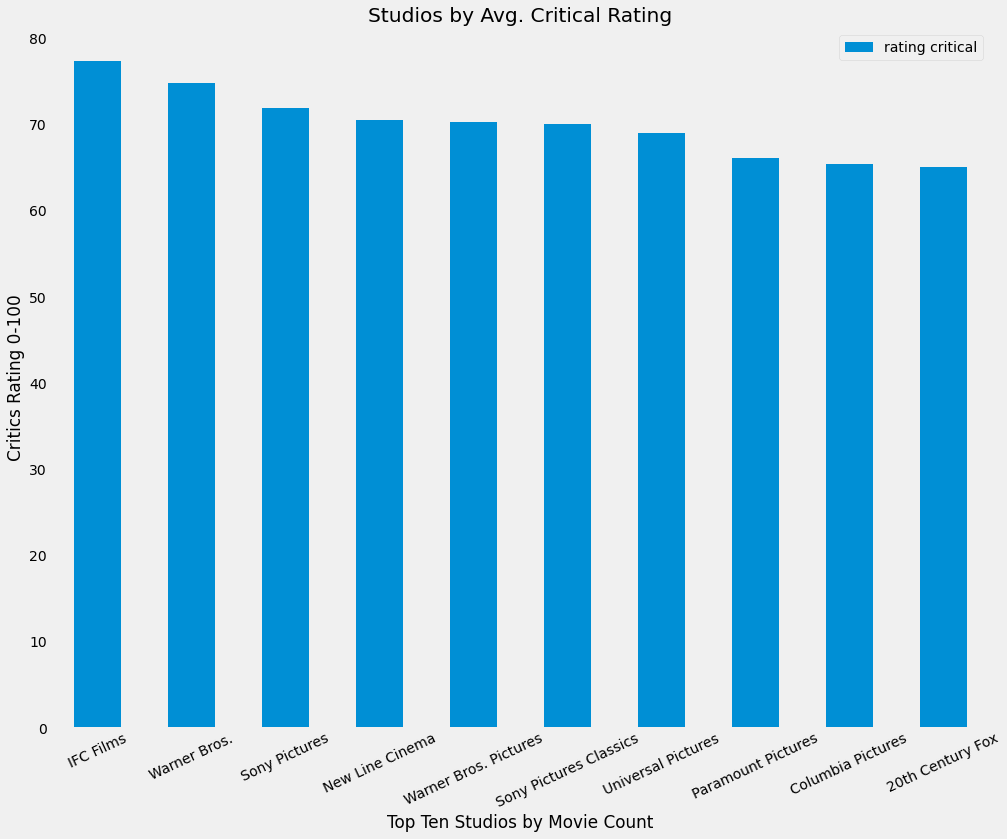

In [24]:
toptenstudios.plot('studio', 'rating critical', kind='bar', rot = 25, figsize = (15,12))

plt.xlabel('Top Ten Studios by Movie Count')
plt.ylabel('Critics Rating 0-100')
plt.title('Studios by Avg. Critical Rating')
plt.grid(False)

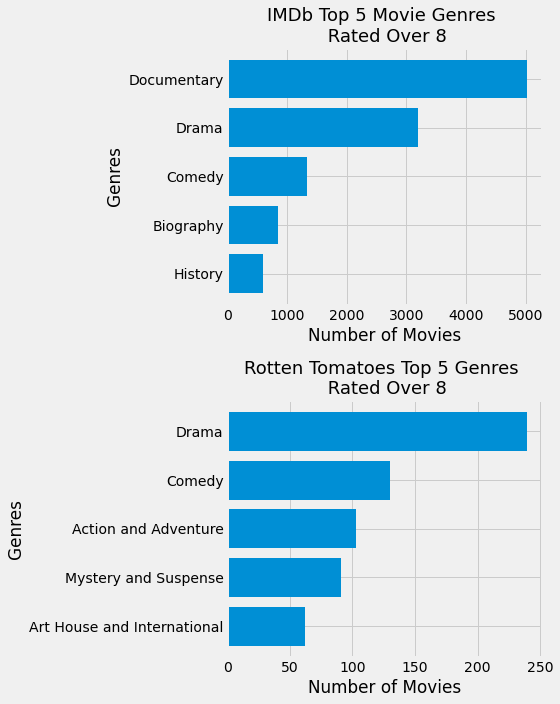

In [25]:
# Creating frequency chart for IMDb and Rotten Tomatoes movie genres with a rating of 8 or above
imdb_x = list(sorted_imdb_genres.keys())[20:]
imdb_y = list(sorted_imdb_genres.values())[20:]

rt_x = list(sorted_rt_genres.keys())[16:]
rt_y = list(sorted_rt_genres.values())[16:]

plt.figure(figsize=(8,10))

plt.subplot(2,1,1)
plt.barh(imdb_x,imdb_y)
plt.title('IMDb Top 5 Movie Genres \n Rated Over 8', fontdict = {'fontsize' : 18})
plt.xlabel('Number of Movies')
plt.ylabel('Genres')

plt.subplot(2,1,2)
plt.barh(rt_x,rt_y)
plt.title('Rotten Tomatoes Top 5 Genres \n Rated Over 8', fontdict = {'fontsize' : 18})
plt.xlabel('Number of Movies')
plt.ylabel('Genres')

plt.tight_layout()
plt.show()

<br>

Graphing writers by ROI

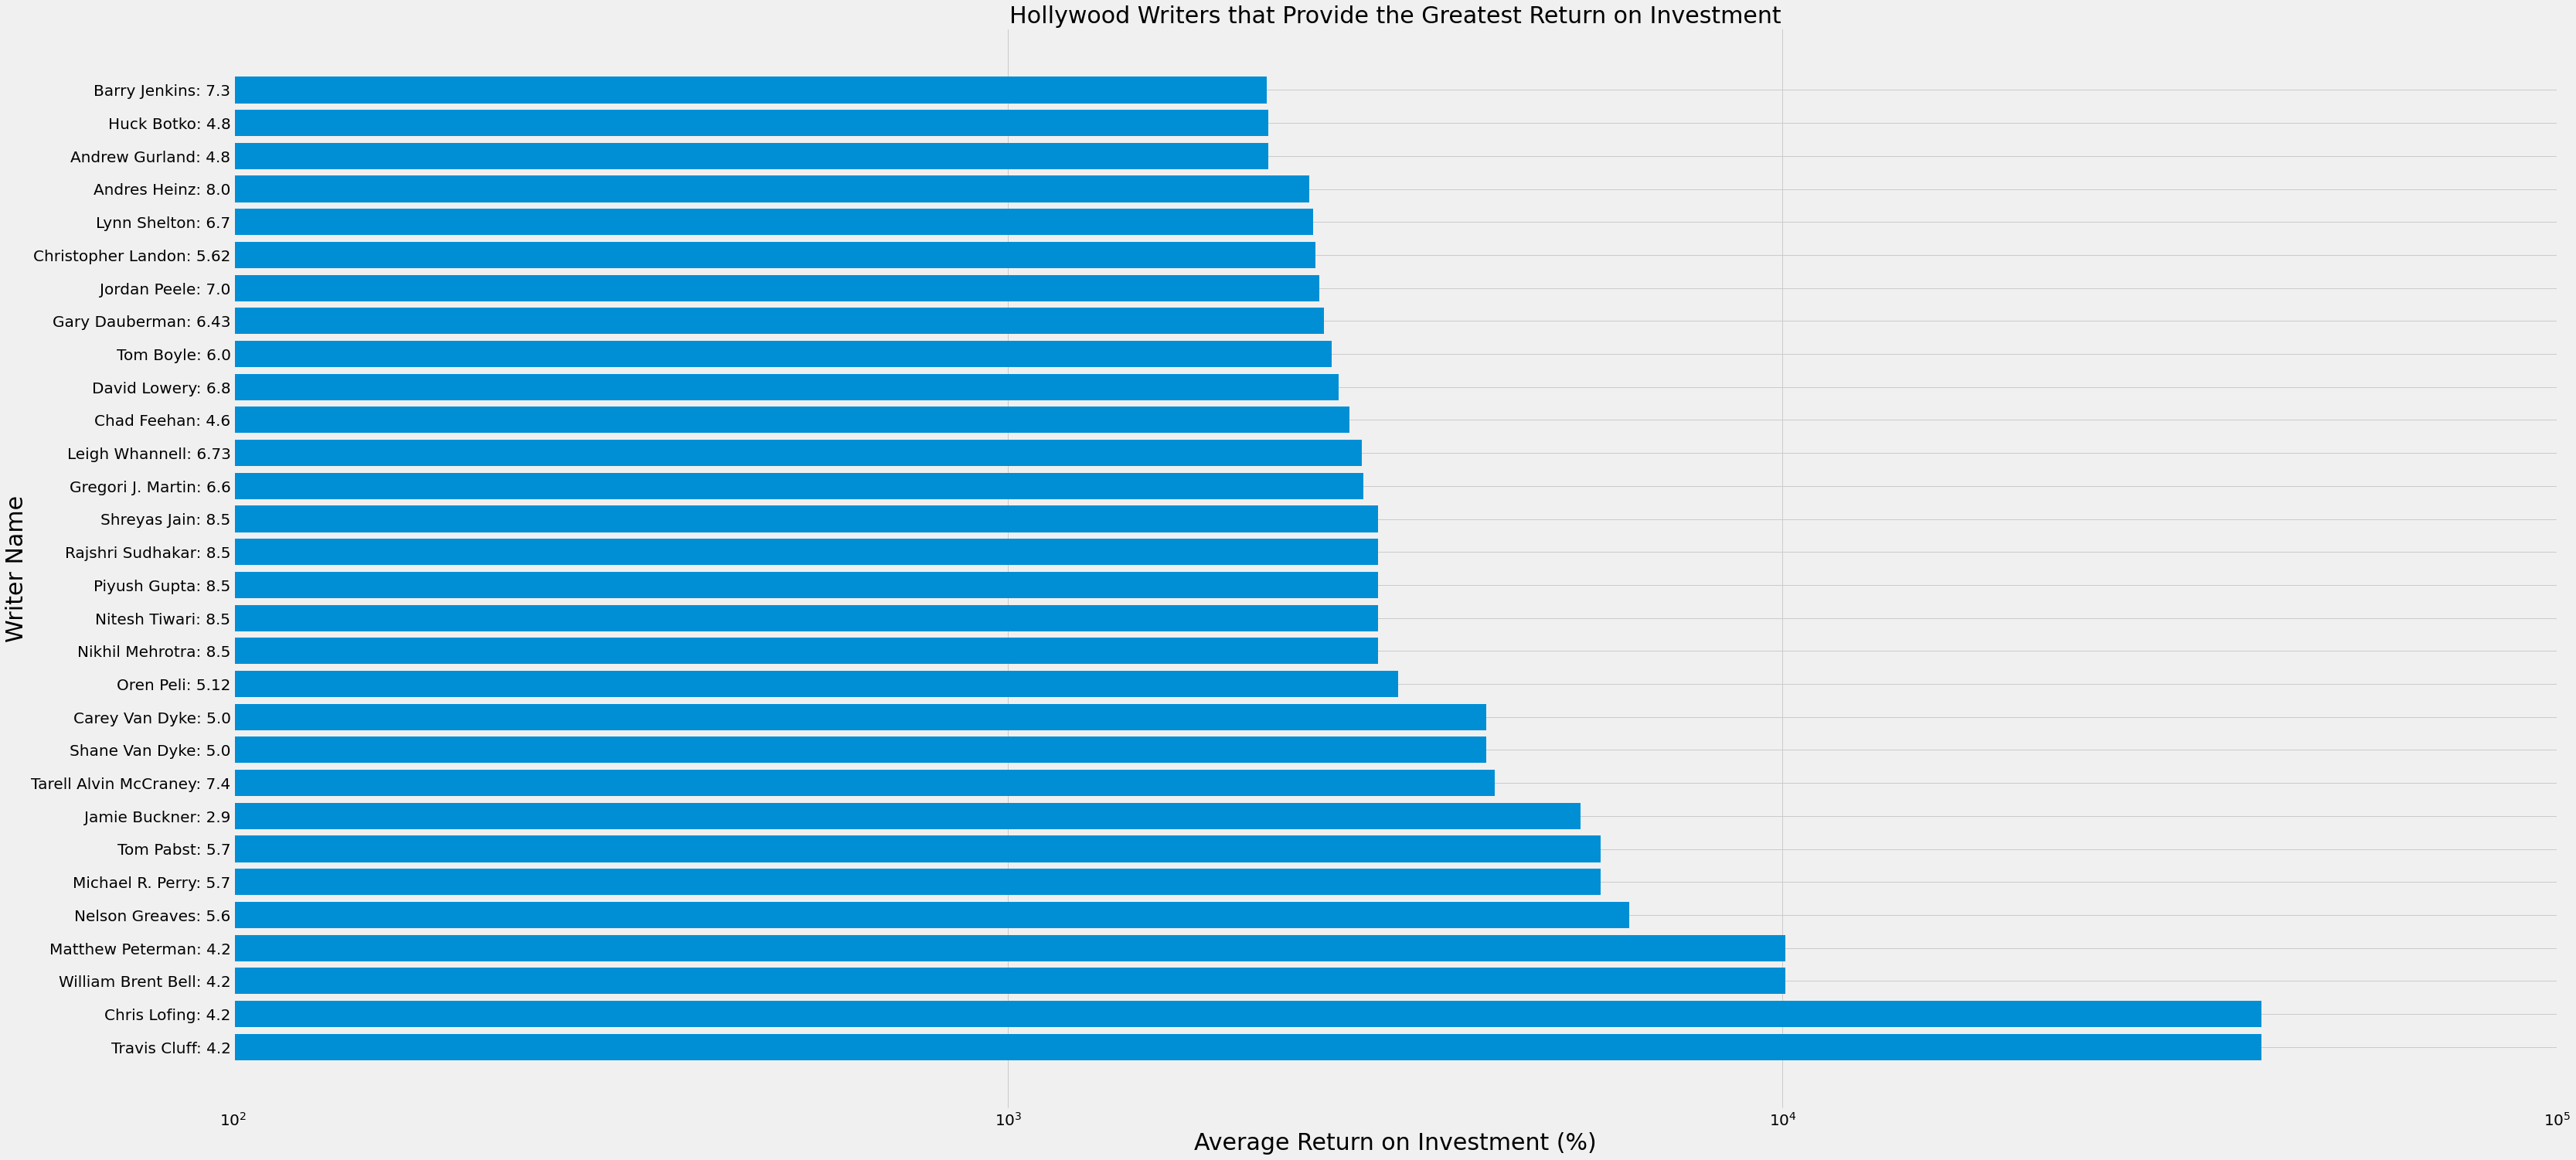

In [26]:
fig, ax = plt.subplots(figsize = (48,24))
x = wnames_wrating
y = writers_plot['ROI']
ax.barh(x,y)
ax.set_xscale('log')
ax.set_xticks([100, 1000, 10000,100000])
ax.set_xlabel('Average Return on Investment (%)', size = 30)
ax.set_title('Hollywood Writers that Provide the Greatest Return on Investment', size = 30)
ax.set_ylabel('Writer Name', size = 30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='y', which='minor', labelsize=20)
plt.style.use('fivethirtyeight');

In [27]:
#table with the top 25 writers and their genres
genres = writers_profit.assign(genres = lambda x :writers_profit['genres'].str.split(',')).explode('genres')
writers_genre = genres.where(genres['ROI'] > 2491).groupby(['primary_name','genres']).mean('ROI').sort_values('averagerating', ascending = False)
top_writers_genre = writers_genre['averagerating']
top_writers_genre

primary_name        genres   
Nikhil Mehrotra     Drama        8.5
Piyush Gupta        Drama        8.5
Nitesh Tiwari       Drama        8.5
Piyush Gupta        Action       8.5
                    Biography    8.5
                                ... 
Travis Cluff        Thriller     4.2
William Brent Bell  Horror       4.2
Jamie Buckner       Sport        2.9
                    Romance      2.9
                    Comedy       2.9
Name: averagerating, Length: 93, dtype: float64

<br>

Graphing directors movie with worlwide gross on the x-axes, average rating on the Y-axis by and the size and color of the marker indicating how many of the axes' the directors had a value that is above the mean. Those that are above the mean of both categories ar ethe ones of interest as they acheive success in both despite there being no correlation bewteen the two variables.

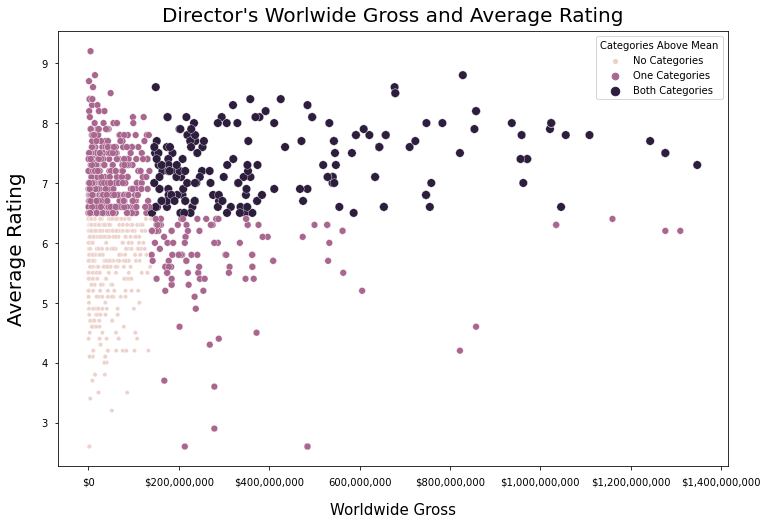

In [10]:
# scatter plot
director_plot = sns.scatterplot(data=director_df, x='worldwide_gross', y='averagerating', 
                                hue='Categories Above Mean', size='Categories Above Mean')

director_plot.set_title('Director\'s Worlwide Gross and Average Rating', fontsize = 20, pad=10)
# 11.7, 8.27
plt.ticklabel_format(style='plain', axis='x')
plt.gcf().set_size_inches(12, 8)
director_plot.tick_params(axis='both', which='major', pad=7)

# X axes 
director_plot.set_xlabel('Worldwide Gross', fontsize = 15)
ticks = [0, 200000000, 400000000, 600000000, 800000000, 1000000000, 1200000000, 1400000000]
labels = ['$0','$200,000,000','$400,000,000', '600,000,000', '$800,000,000','$1,000,000,000', '$1,200,000,000', '$1,400,000,000']
plt.xticks(ticks, labels)
director_plot.xaxis.labelpad = 15

# Y axes
director_plot.set_ylabel('Average Rating', fontsize = 20)
director_plot.yaxis.labelpad = 15

# legend 
zero_label = 'No Categories'
one_label = 'One Categories'
two_label = 'Both Categories'
director_plot.legend_.texts[0].set_text(zero_label)
director_plot.legend_.texts[1].set_text(one_label)
director_plot.legend_.texts[2].set_text(two_label);

## Evaluation

<br>

There is no correlation between a director's average worldwide gross and average movie rating. This is true for the entire dataset of directors and gives us confidence that the results will generalize beyond the data in this analysis. 

## Conclusions

<br>

For Microsoft's movies to compete against those from other big studios by producing both finacially succesful and high quality movies, we reccomend that they specifically target directors that have exceeded in both.